In [1]:
import pandas as pd
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, reweight_laplace
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
# load mobility matrix
data = pd.read_csv('../../../Dropbox/Epidemiology/trajectories/nys_commuting_counties.csv', index_col = 0).values
data = [i / np.sum(i) for i in data]
R = np.array(data)
M = R.shape[0]
np.sum(R, axis=0)

array([3.04470101, 0.63298709, 0.65432751, 1.5175129 , 0.78085325,
       0.6341433 , 0.87459994, 1.00571173, 0.68504912, 1.01402755,
       0.63915968, 0.65825195, 0.66197261, 1.04407087, 2.80167096,
       0.80280225, 0.83361601, 0.67170434, 0.66538914, 0.48316792,
       0.5704564 , 0.52324962, 1.10463661, 1.22121747, 0.52581269,
       0.58765684, 0.50016525, 3.22377082, 0.69175819, 1.20546935,
       4.12656194, 0.67824499, 1.75265207, 2.67871074, 1.18177785,
       1.11429053, 0.44422598, 0.63481357, 0.87829422, 0.30881013,
       1.04058779, 0.68213382, 0.38948335, 0.74921793, 0.97165063,
       1.27478184, 0.9820337 , 0.50643875, 0.39695896, 0.53155178,
       1.06668606, 1.25653031, 0.60235276, 0.41815181, 1.51938207,
       0.82304881, 0.99505599, 0.47844257, 0.57760229, 1.59708697,
       0.55656234, 0.52596506])

In [3]:
# compartment parameters
C = 4

def make_trans_mats(N):
    T = np.zeros((N,C,C))
    dist = lambda : ss.beta.rvs(1, 100)
    for i in range(N):
        Ti = np.zeros((C,C))
        Ti[0,1] = dist()
        Ti[0,2] = dist()
        Ti[1,3] = dist()
        Ti[2,3] = dist()
        # get what leaves
        np.fill_diagonal(Ti, 1 - np.sum(Ti, axis=1))
        T[i] = Ti
    return T
T = make_trans_mats(1)
print(T[0])
print([1,0,0,0] @ T[0])

[[0.95480519 0.04200434 0.00319047 0.        ]
 [0.         0.99716149 0.         0.00283851]
 [0.         0.         0.98484277 0.01515723]
 [0.         0.         0.         1.        ]]
[0.95480519 0.04200434 0.00319047 0.        ]


In [4]:
f = [0.8,0,0,0]
for i in range(3):
    f = f @ T[0]
    #f = np.clip(f, 0,1)
    #f /= np.sum(f)
    print(f, np.sum(f))

[0.76384415 0.03360347 0.00255238 0.        ] 0.8
[7.29322360e-01 6.55928574e-02 4.95071227e-03 1.34070581e-04] 0.8000000000000002
[6.96360774e-01 9.60413759e-02 7.20255496e-03 3.95295315e-04] 0.7999999999999999


In [5]:
# starting fractions
def make_starts(N):
    start = np.zeros((N, M, C))
    # pick 2 starting patches
    seeds = [[0, 1]]
    for i in range(N):
        for j in np.random.randint(0, M, size=5): #seeds:
            start[i,j,0] = ss.beta.rvs(1, 100)
    return start

In [6]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 512
batches = 8
outs = []
for b in tqdm.tqdm(range(batches)):
    start = make_starts(N)
    Rmat = np.tile(R[np.newaxis,:,:], [N,1,1])
    infect = contact_infection_func(tf.constant([np.random.uniform(0.01,0.2) for _ in range(N)]))
    T = make_trans_mats(N)
    model = MetaModel(start, Rmat, T, infect)
    outs.append(model.run(1000))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.99s/it]


(4096, 1000, 62, 5)


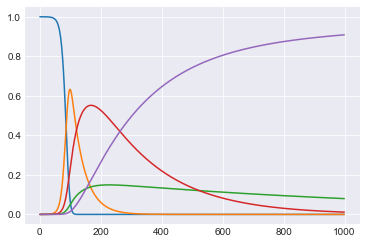

In [7]:
plt.plot(trajs[0,:,0,:])
plt.show()

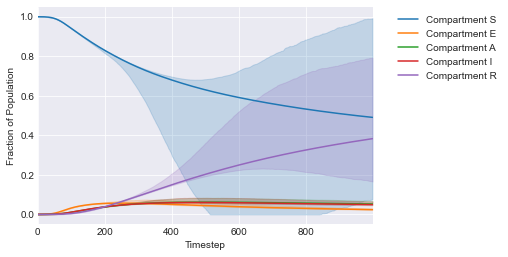

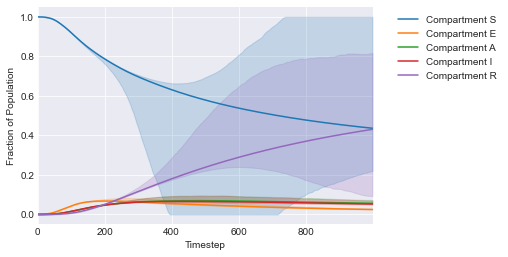

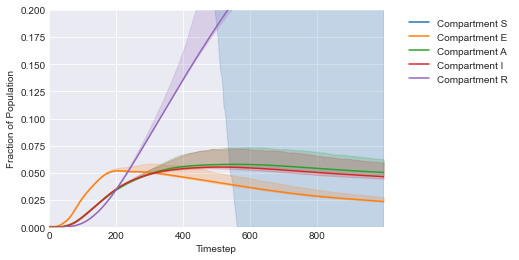

In [8]:
traj_quantile(trajs[:,:,0,:], names=['S', 'E', 'A', 'I', 'R'], plot_means=True)
plt.show()
traj_quantile(trajs[:,:,1,:], names=['S', 'E', 'A', 'I', 'R'], plot_means=True)
plt.show()
traj_quantile(trajs[:,:,2,:], names=['S', 'E', 'A', 'I', 'R'], plot_means=True)
plt.ylim(0,0.2)
plt.show()

In [9]:
restraints = np.array([
    [0.4, 0, 250, 0, 0],
    [0.12,0.05,200,2,1],
    [0.8, 0.1,900, 1, 4],
    [0.6, 0, 250, 34, 4],
    [0.4, 0, 250, 24, 0],
             ])
laplace_restraints = []
for i in range(len(restraints)):
    traj_index = tuple(restraints[i, 2:].astype(np.int))
    value = restraints[i, 0]
    uncertainty = restraints[i, 1]
    p = maxentep.Laplace(uncertainty)
    r = maxentep.Restraint(lambda traj: traj[traj_index], value, p)
    laplace_restraints.append(r)

In [10]:
sigmas = np.array([r.prior.sigma for r in laplace_restraints], dtype=np.float32)
sigmas = np.tile(sigmas[np.newaxis, :], [trajs.shape[0], 1])
sigmas.shape

(4096, 5)

In [34]:
model = maxentep.MaxentModel(laplace_restraints)
model.compile(tf.keras.optimizers.Nadam(learning_rate=1e-3), 'mean_absolute_error')

In [35]:
history = model.fit(trajs, batch_size=64, epochs=100)

Epoch 1/100
64/64 [==============================] - 0s 3ms/step - loss: 1.4209 - output_2_loss: 1.4209
Epoch 2/100
64/64 [==============================] - 0s 3ms/step - loss: 1.4197 - output_2_loss: 1.4197
Epoch 3/100
64/64 [==============================] - 0s 3ms/step - loss: 1.4182 - output_2_loss: 1.4182
Epoch 4/100
64/64 [==============================] - 0s 3ms/step - loss: 1.4162 - output_2_loss: 1.4162
Epoch 5/100
64/64 [==============================] - 0s 3ms/step - loss: 1.4133 - output_2_loss: 1.4133
Epoch 6/100
64/64 [==============================] - 0s 3ms/step - loss: 1.4089 - output_2_loss: 1.4089
Epoch 7/100
64/64 [==============================] - 0s 3ms/step - loss: 1.4012 - output_2_loss: 1.4012
Epoch 8/100
64/64 [==============================] - 0s 3ms/step - loss: 1.3880 - output_2_loss: 1.3880
Epoch 9/100
64/64 [==============================] - 0s 3ms/step - loss: 1.3622 - output_2_loss: 1.3622
Epoch 10/100
64/64 [==============================] - 0s 3ms/ste

64/64 [==============================] - 0s 3ms/step - loss: 0.8098 - output_2_loss: 0.8098
Epoch 79/100
64/64 [==============================] - 0s 3ms/step - loss: 0.8096 - output_2_loss: 0.8096
Epoch 80/100
64/64 [==============================] - 0s 3ms/step - loss: 0.8096 - output_2_loss: 0.8096
Epoch 81/100
64/64 [==============================] - 0s 3ms/step - loss: 0.8095 - output_2_loss: 0.8095
Epoch 82/100
64/64 [==============================] - 0s 3ms/step - loss: 0.8096 - output_2_loss: 0.8096
Epoch 83/100
64/64 [==============================] - 0s 3ms/step - loss: 0.8093 - output_2_loss: 0.8093
Epoch 84/100
64/64 [==============================] - 0s 3ms/step - loss: 0.8092 - output_2_loss: 0.8092
Epoch 85/100
64/64 [==============================] - 0s 3ms/step - loss: 0.8091 - output_2_loss: 0.8091
Epoch 86/100
64/64 [==============================] - 0s 3ms/step - loss: 0.8092 - output_2_loss: 0.8092
Epoch 87/100
64/64 [==============================] - 0s 3ms/step - 

In [36]:
model.summary()

Model: "maxent-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
maxent_layer_laplace_3 (Maxe multiple                  5         
_________________________________________________________________
reweight_layer_laplace_3 (Re multiple                  5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [37]:
history.history.keys()

dict_keys(['loss', 'output_2_loss'])

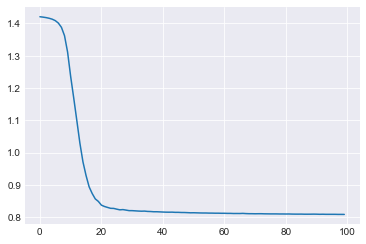

In [38]:
plt.plot(history.history['loss'])

TensorShape([4096])

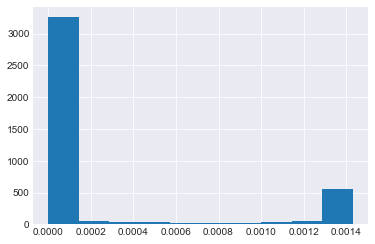

In [39]:
weights = model.traj_weights
plt.hist(weights)
weights.shape

In [40]:
#patch_quantile(trajs, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
#plt.show()

In [41]:
#patch_quantile(trajs, weights=weights, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
#plt.show()

In [49]:
float(model.lambdas[0])

4.462302207946777

In [46]:
laplace_restraints[0].prior.expected(model.lambdas[0])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0>

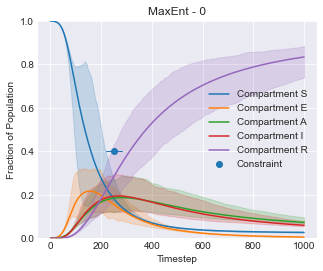

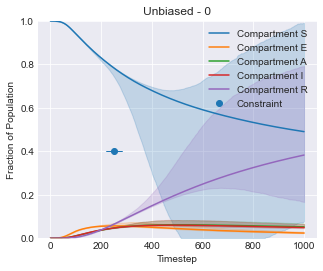

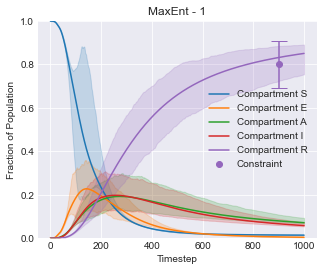

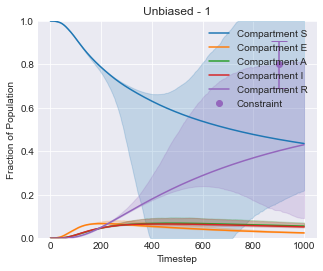

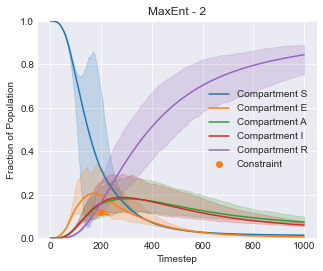

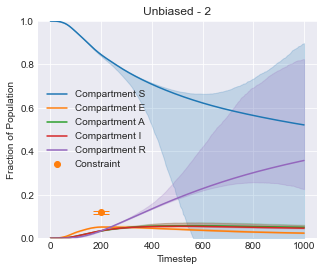

In [ ]:
for p in [0,1,2,34,24]:
    plt.figure(figsize=(5,4))
    plt.title(f'MaxEnt - {p}')
    traj_quantile(trajs[:,:,p,:], weights, add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()
    plt.figure(figsize=(5,4))
    plt.title(f'Unbiased - {p}')
    traj_quantile(trajs[:,:,p,:], add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()